In [16]:
import pandas as pd
import numpy as np
from composition_stats import closure, clr, ilr

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.preprocessing import LabelEncoder

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.feature_selection import SelectKBest
from mrmr import mrmr_classif


In [17]:
from sklearn.model_selection import RepeatedStratifiedKFold

In [18]:
datasets = ["CD2", "CIR", "PAR2", "OB"]
skf = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=42)

In [ ]:
models = {
    'LogisticRegression': LogisticRegression(random_state=42), 
}
param_grids = {
    'LogisticRegression': {
        'C': np.logspace(-4, 4, 20),
    }
}

In [38]:
    skf = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=42)
    results = pd.DataFrame(columns=['Dataset', 'Model', 'best_params'])
    for dataset in datasets: 
        df = pd.read_csv("data/"+dataset+ ".csv")
        y = df["label"]
        df.drop("label", axis=1, inplace=True)
        df = clr(closure(df+0.5))
        label_encoder = LabelEncoder()
        y = label_encoder.fit_transform(y.squeeze())
        
        for model_name, model in models.items():
                grid = GridSearchCV(estimator=model, param_grid=param_grids[model_name], cv=skf, scoring='roc_auc', n_jobs=-1, verbose=1)
                grid.fit(df, y)        
                best_model = grid.best_estimator_
                best_params = grid.best_params_           
                results.loc[len(results)] = [dataset, model_name, best_params]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [ ]:
hyper = results.copy()

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.feature_selection import SelectKBest, mutual_info_classif

def run_experiment_mifs():
    results = pd.DataFrame(columns=['Dataset', 'Model', 'n_features', 'AUC', 'Accuracy', 'AUCdeviation'])
    
    for dataset in datasets: 
        df = pd.read_csv("data/"+dataset+ ".csv")
        y = df["label"]
        df.drop("label", axis=1, inplace=True)
        df = clr(closure(df+0.5))
        label_encoder = LabelEncoder()
        y = label_encoder.fit_transform(y.squeeze())
        
        for model_name, model in models.items():

            for i in np.arange(2, 122, 2):
                m = model.set_params(**hyper[(hyper["Dataset"]==dataset) & (hyper["Model"]==model_name)]["best_params"].iloc[0])
                pipe = Pipeline([
                    ('feature_selection', SelectKBest(mutual_info_classif, k=i)),
                    ('classifier', m)
                ])
                scores = cross_validate(pipe, df, y, cv=skf, scoring=['roc_auc', 'accuracy'], n_jobs=-1)
                
                # Guardar las métricas
                auc_mean = scores['test_roc_auc'].mean()
                deviation = scores['test_roc_auc'].std()
                accuracy_mean = scores['test_accuracy'].mean()
                
                results.loc[len(results)] = [dataset, model_name, i, auc_mean, accuracy_mean, deviation]
                print([dataset, model_name, i, auc_mean, accuracy_mean, deviation])
    
    return results

resultados_finales_mifs = run_experiment_mifs()

['CD2', 'LogisticRegression', 2, 0.5722704196388406, 0.575, 0.11555860094586443]
['CD2', 'LogisticRegression', 4, 0.6207088233404023, 0.59375, 0.1087308431116653]
['CD2', 'LogisticRegression', 6, 0.7229708887603625, 0.64375, 0.1296140752055332]
['CD2', 'LogisticRegression', 8, 0.775914144335197, 0.68125, 0.0753063928768751]
['CD2', 'LogisticRegression', 10, 0.7750401645138486, 0.68125, 0.09556985117529422]
['CD2', 'LogisticRegression', 12, 0.779120879120879, 0.6625, 0.09167126037179524]
['CD2', 'LogisticRegression', 14, 0.7798984641089903, 0.6875, 0.0865246828165114]
['CD2', 'LogisticRegression', 16, 0.7734689287320867, 0.68125, 0.07393227489796596]
['CD2', 'LogisticRegression', 18, 0.807364565259302, 0.7125, 0.0474776032928208]
['CD2', 'LogisticRegression', 20, 0.8200951095687937, 0.71875, 0.026652959308915772]
['CD2', 'LogisticRegression', 22, 0.8312062206799048, 0.75, 0.028492441560411853]
['CD2', 'LogisticRegression', 24, 0.8359520596362702, 0.75, 0.03200355402373257]
['CD2', 'Logi

In [ ]:
from mrmr_feature_selector import MRMRFeatureSelector

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.feature_selection import SelectKBest, mutual_info_classif

def run_experiment_mrmr():
    results = pd.DataFrame(columns=['Dataset', 'Model', 'n_features', 'AUC', 'Accuracy', 'AUCdeviation'])
    
    for dataset in datasets: 
        df = pd.read_csv("data/"+dataset+ ".csv")
        y = df["label"]
        df.drop("label", axis=1, inplace=True)
        df = pd.DataFrame(clr(closure(df+0.5)))
        label_encoder = LabelEncoder()
        y = label_encoder.fit_transform(y.squeeze())
        
        for model_name, model in models.items():

            for i in np.arange(2, 122, 2):
                m = model.set_params(**hyper[(hyper["Dataset"]==dataset) & (hyper["Model"]==model_name)]["best_params"].iloc[0])
                pipe = Pipeline([
                    ('feature_selection', MRMRFeatureSelector(num_features=i)),
                    ('classifier', m)
                ])
                scores = cross_validate(pipe, df, y, cv=skf, scoring=['roc_auc', 'accuracy'], n_jobs=-1)
                
                # Guardar las métricas
                auc_mean = scores['test_roc_auc'].mean()
                deviation = scores['test_roc_auc'].std()
                accuracy_mean = scores['test_accuracy'].mean()
                
                results.loc[len(results)] = [dataset, model_name, i, auc_mean, accuracy_mean, deviation]
                print([dataset, model_name, i, auc_mean, accuracy_mean, deviation])
    
    return results

resultados_finales_mrmr = run_experiment_mrmr()

['CD2', 'LogisticRegression', 2, 0.7804607673028726, 0.75, 0.056071458464615295]
['CD2', 'LogisticRegression', 4, 0.7804607673028726, 0.75, 0.056071458464615295]
['CD2', 'LogisticRegression', 6, 0.7812544180965234, 0.75, 0.056280232146258366]
['CD2', 'LogisticRegression', 8, 0.7891909260330313, 0.6875, 0.05418406518930647]
['CD2', 'LogisticRegression', 10, 0.8338281601439498, 0.7375, 0.03108706620341822]
['CD2', 'LogisticRegression', 12, 0.8737998843262, 0.76875, 0.035465697701280004]
['CD2', 'LogisticRegression', 14, 0.8713546687230898, 0.78125, 0.038735327635744096]
['CD2', 'LogisticRegression', 16, 0.8713546687230898, 0.7625, 0.03631481591449654]
['CD2', 'LogisticRegression', 18, 0.8705449521238995, 0.775, 0.03536580979437897]
['CD2', 'LogisticRegression', 20, 0.8705449521238995, 0.7875, 0.03334916122355156]
['CD2', 'LogisticRegression', 22, 0.8705770837349783, 0.775, 0.03424403503283246]
['CD2', 'LogisticRegression', 24, 0.8705931495405179, 0.775, 0.03663136894024204]
['CD2', 'Logi

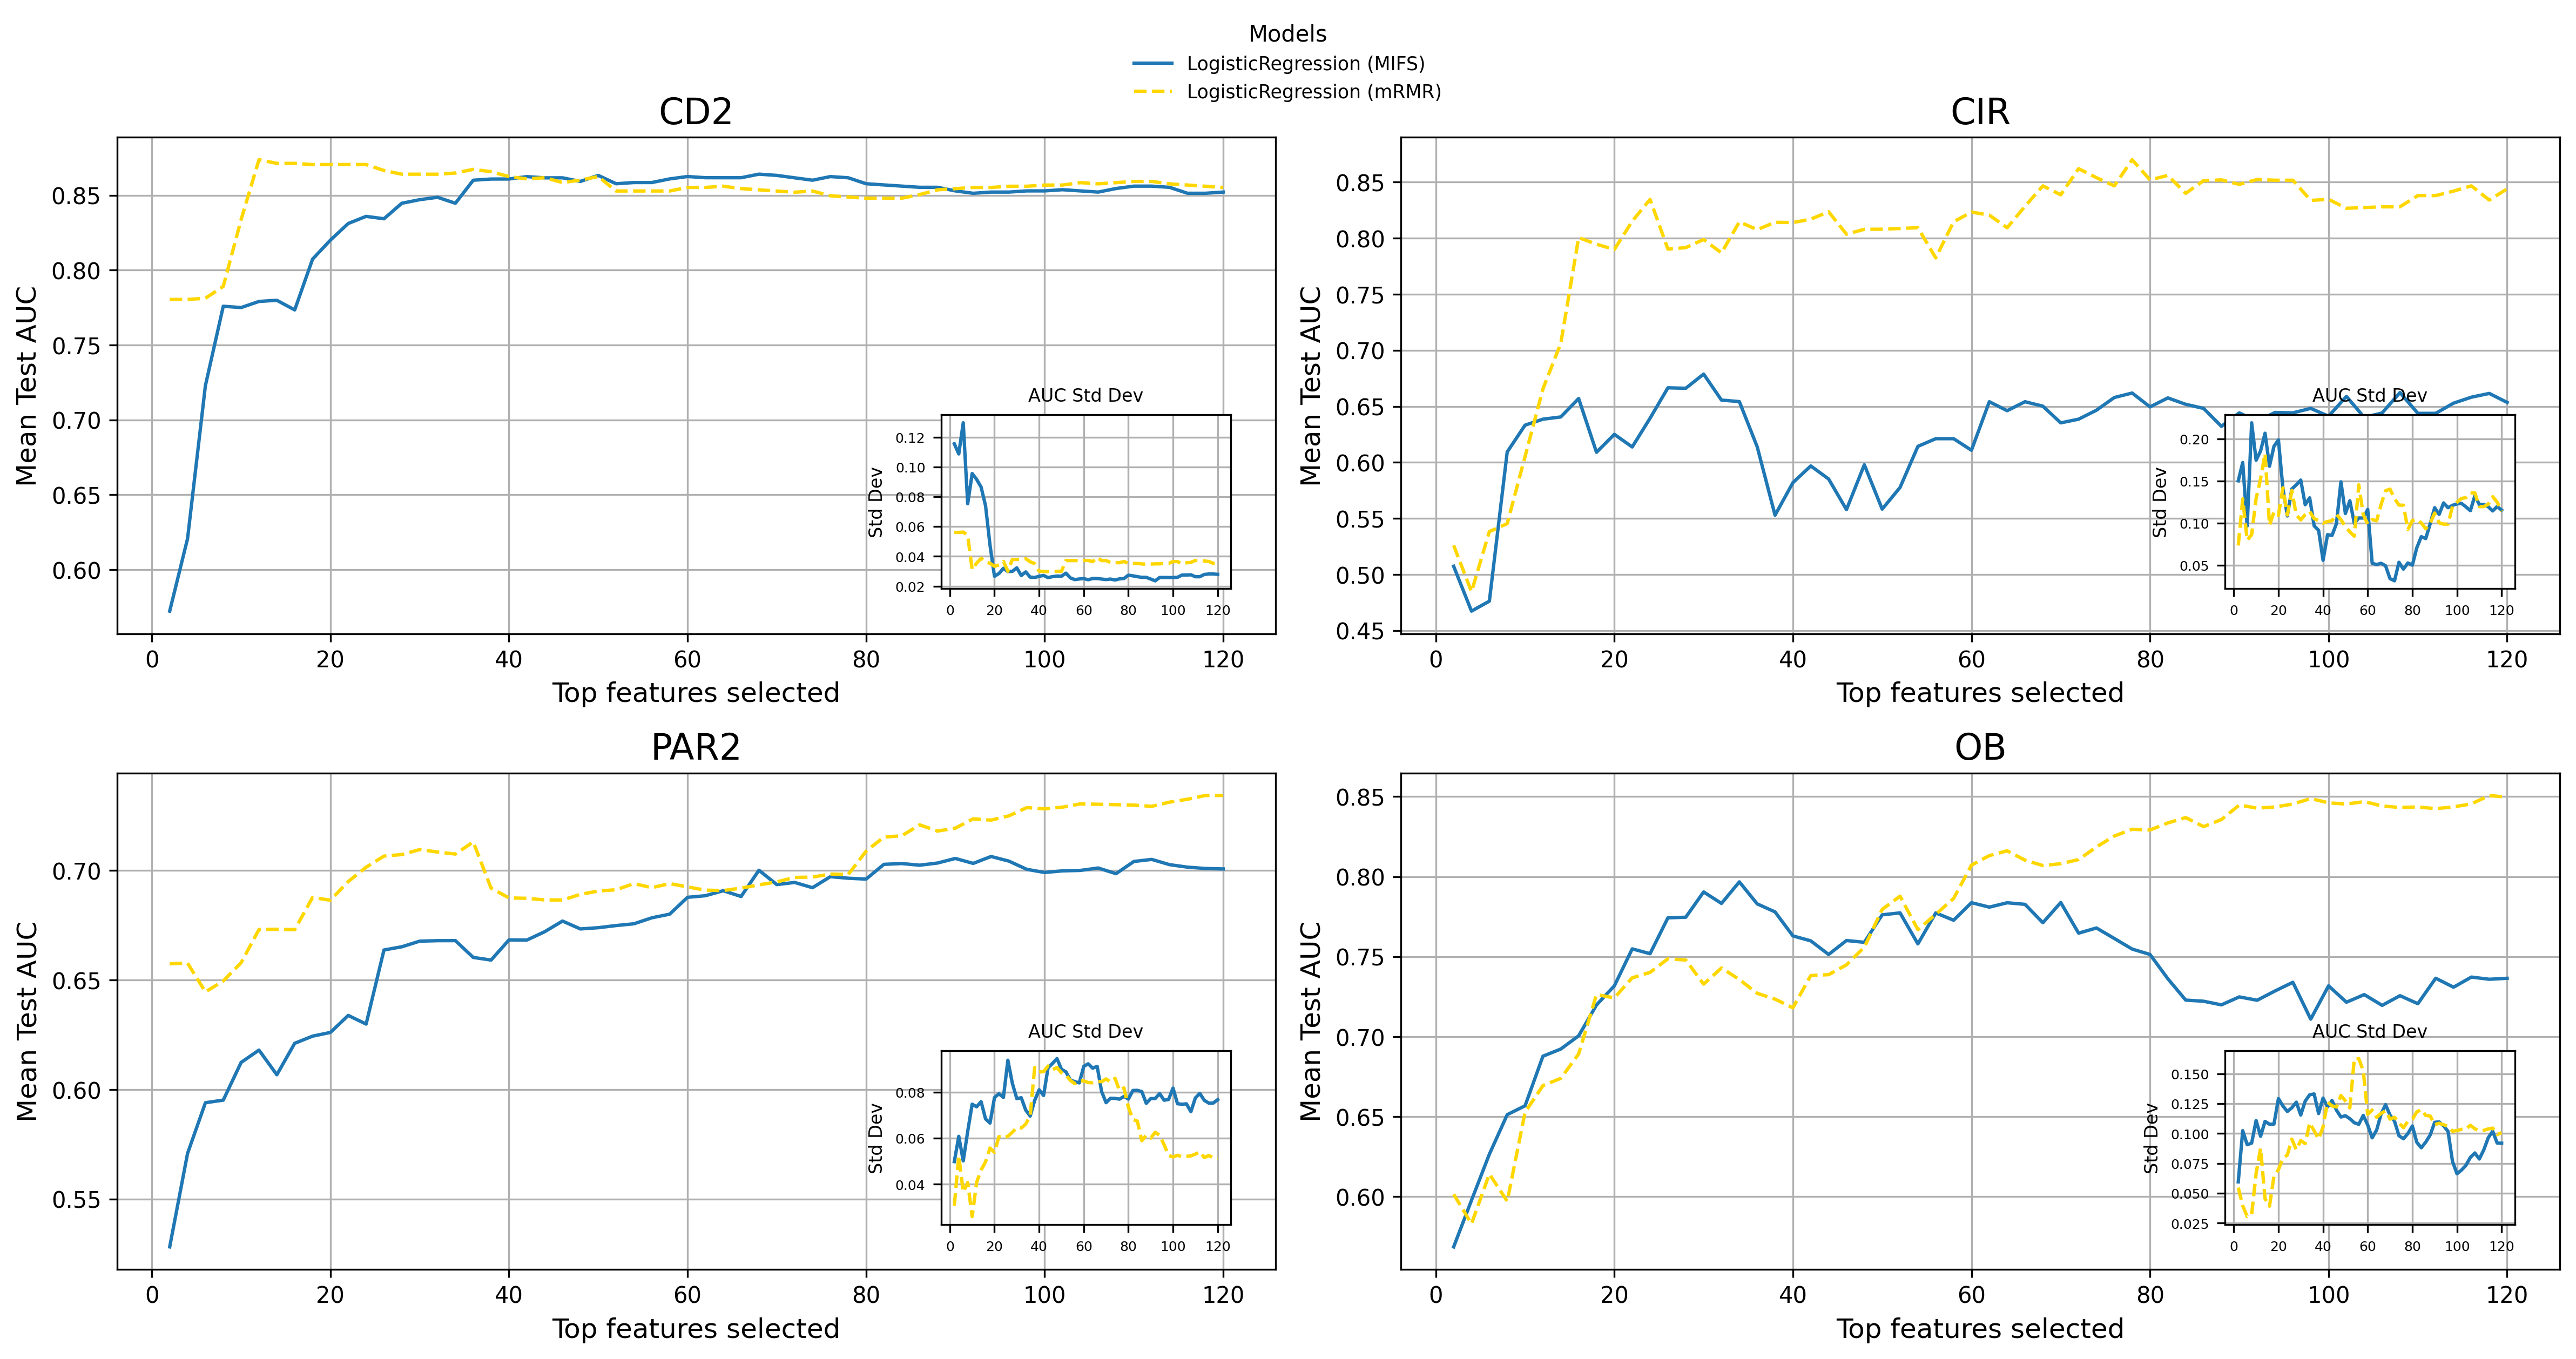

In [33]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Crear una figura con 2 filas y 2 columnas, más ancha que alta
fig, axes = plt.subplots(2, 2, figsize=(16, 8), dpi=300)  # Ancho aumentado y altura reducida
axes = axes.flatten()  # Aplanar la matriz de ejes

# Paleta de colores para los modelos
colors_solid = plt.cm.tab10(range(len(models)))

# Graficar cada dataset en su respectivo subplot
for i, d in enumerate(datasets):
    ax = axes[i]
    
    for idx, m in enumerate(models):
        # MIFS (línea sólida, tab10)
        subset_mifs = resultados_finales_mifs[(resultados_finales_mifs["Dataset"] == d) & (resultados_finales_mifs["Model"] == m)]
        if not subset_mifs.empty:
            ax.plot(subset_mifs["n_features"], subset_mifs["AUC"], label=f'{m} (MIFS)', linestyle='-', color=colors_solid[idx])
        
        # mRMR (línea discontinua amarilla)
        subset_mrmr = resultados_finales_mrmr[(resultados_finales_mrmr["Dataset"] == d) & (resultados_finales_mrmr["Model"] == m)]
        if not subset_mrmr.empty:
            ax.plot(subset_mrmr["n_features"], subset_mrmr["AUC"], label=f'{m} (mRMR)', linestyle='--', color='gold')
    
    # Configuraciones del subplot
    ax.set_title(d, fontsize=16)
    ax.set_xlabel('Top features selected', fontsize=12)
    ax.set_ylabel('Mean Test AUC', fontsize=12)
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.grid(True)
    
    # Gráfica pequeña para desviación estándar
    ax_inset = inset_axes(ax, width="25%", height="35%", loc="lower right", borderpad=2)  # Inset más compacto
    for idx, m in enumerate(models):
        subset_mifs = resultados_finales_mifs[(resultados_finales_mifs["Dataset"] == d) & (resultados_finales_mifs["Model"] == m)]
        if not subset_mifs.empty:
            ax_inset.plot(subset_mifs["n_features"], subset_mifs["AUCdeviation"], linestyle='-', color=colors_solid[idx])
        
        subset_mrmr = resultados_finales_mrmr[(resultados_finales_mrmr["Dataset"] == d) & (resultados_finales_mrmr["Model"] == m)]
        if not subset_mrmr.empty:
            ax_inset.plot(subset_mrmr["n_features"], subset_mrmr["AUCdeviation"], linestyle='--', color='gold')
    
    ax_inset.set_title('AUC Std Dev', fontsize=8)
    ax_inset.set_ylabel('Std Dev', fontsize=8)
    ax_inset.tick_params(axis='both', which='major', labelsize=6)
    ax_inset.grid(True)

# Leyenda común fuera de los ejes
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, title='Models', loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=len(models), fontsize='small', frameon=False)

plt.tight_layout()
plt.savefig('c:/Users/ignan/combined_comparison.jpg', format='jpg', dpi=600, bbox_inches='tight')
plt.show()


